In [2]:
Product_ID = 'DTEED_024728_1595_024227_1595_A01'
img_path = 'data/DTM/' + Product_ID + '.IMG'
jpg_path = 'data/JPG/' + Product_ID + '.ca.jpg'

In [ ]:
# 显示jpg
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(jpg_path)
plt.imshow(img)
plt.axis('off')
# 图片输出，PNG
img.save('data/JPG/' + Product_ID + '.png', 'PNG')

In [4]:
from osgeo import gdal
import numpy as np

dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  3497 x 10431 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3393833.2607584,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-20],PARAMETER["central_meridian",329.99],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -3537.394372595001 , -1204253.7512038578 )
Pixel Size = ( 2.0179089404421 , -2.0179089404421 )
ignore_value:  -3.4028226550889045e+38


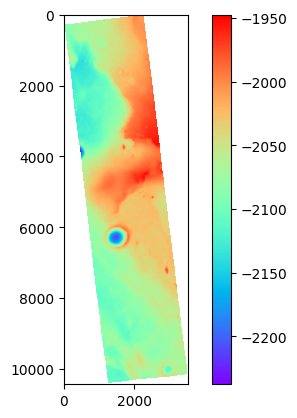

In [5]:
# ignore_value用NAN替代
data[data == ignore_value] = np.NAN
# data画图,带色条
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data, cmap='rainbow')
plt.colorbar()
plt.show()

In [6]:
# 划分方格
data_mask = np.isnan(data)
center = [int(data_mask.shape[0] / 2), int(data_mask.shape[1] / 2)]
# 取出最大区域全为true的区域
count = 1
while True:
    if np.all(data_mask[center[0] - count: center[0] + count + 1, center[1] - count: center[1] + count + 1] == False):
        count += 1
    else:
        count -= 1
        break
center_index = count

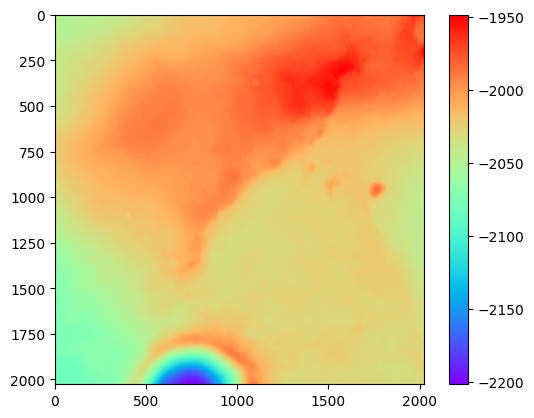

In [7]:
data_cut = data[center[0] - count: center[0] + count + 1, center[1] - count: center[1] + count + 1]
plt.imshow(data_cut, cmap='rainbow')
plt.colorbar()

In [8]:
geotransform = dataset.GetGeoTransform()
if abs(geotransform[1]) != abs(geotransform[5]):
    print('warning: 两个方向上的距离间隔不一致')
map_scale = abs(geotransform[1])
actural_interval = 100  # m
interval = int(actural_interval / map_scale)
if interval % 2 == 0:
        interval = interval + 1

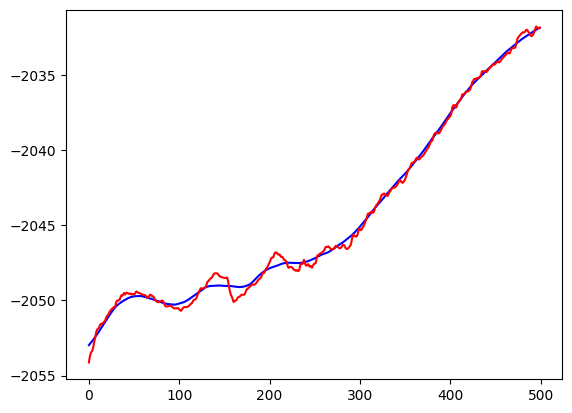

In [9]:
from numpy.fft import fft,ifft,fftshift,ifftshift
def filter_1d_fft(dem,_interval):
    filter_dem = np.pad(dem, (_interval, _interval), 'edge')
    _filter_kernel = np.ones(_interval) / _interval
    _filter_pad_size = int((filter_dem.shape[0] - _interval)/2)
    _filter_kernel = np.pad(_filter_kernel, (_filter_pad_size, _filter_pad_size), 'constant')
    
    filter_dem_fft = fft(filter_dem)
    filter_kernel_fft = fft(_filter_kernel)
    
    filtered_result = filter_dem_fft * filter_kernel_fft
    
    filtered_result = fftshift(ifft(filtered_result)).real
    
    big_scale_dem = filtered_result[interval:-interval]
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem,small_scale_dem


bs_1d, ss_1d = filter_1d_fft(data_cut[0, :], interval)
x_max_limit = 500
plt.plot(bs_1d[:x_max_limit], 'b')
plt.plot(data_cut[0, :x_max_limit], 'r')

(-2.0, 2.0)

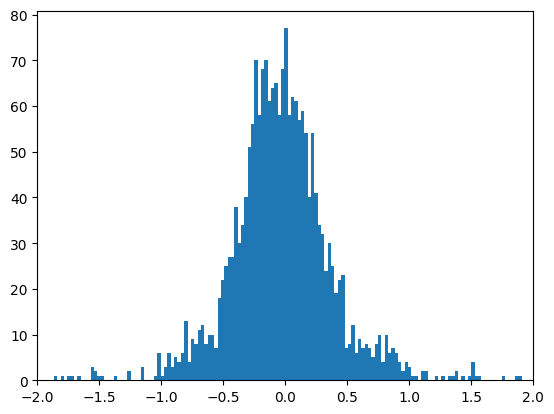

In [10]:
plt.hist(ss_1d,bins=150)
plt.xlim(-2,2)

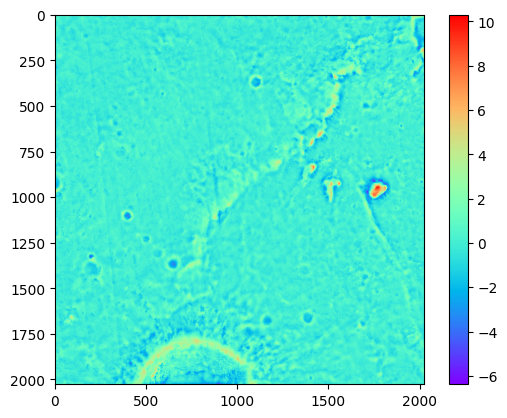

In [11]:
from numpy.fft import fft2,ifft2
def filter_2d_fft(dem, _interval):
    # 对数据进行零填充，以便与滤波器核进行卷积
    padded_dem = np.pad(dem, ((_interval, _interval), (_interval, _interval)), 'edge')
    
    # 生成滤波器核，并对其进行零填充以匹配输入数据的尺寸
    _filter_kernel = np.ones((_interval, _interval)) / (_interval ** 2)
    _filter_pad_size = int((padded_dem.shape[0]-_interval)/2)
    padded_kernel = np.pad(_filter_kernel, ((_filter_pad_size, _filter_pad_size), (_filter_pad_size, _filter_pad_size)), 'constant')
    
    # 计算输入数据和滤波器核的二维傅里叶变换
    dem_fft = fft2(padded_dem)
    kernel_fft = fft2(padded_kernel)
    
    # 频域相乘
    result_fft = dem_fft * kernel_fft
    
    # 逆二维傅里叶变换回到空间域
    filtered_result = fftshift(ifft2(result_fft)).real
    
    # 截取有效部分
    big_scale_dem = filtered_result[_interval:-_interval, _interval:-_interval]
    
    # 计算小尺度细节
    small_scale_dem = dem - big_scale_dem
    
    return big_scale_dem, small_scale_dem


bs_2d, ss_2d = filter_2d_fft(data_cut, interval)
plt.imshow(ss_2d, cmap='rainbow')
plt.colorbar()

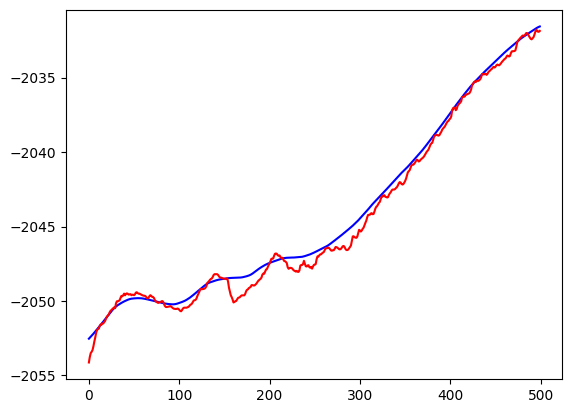

In [12]:
#对比x轴第一条的bs_2d和ss_2d，和y轴第一条的bs_2d和ss_2d
plt.plot(bs_2d[0,:500],'b')
plt.plot(data_cut[0,:500],'r')

(-2.0, 2.0)

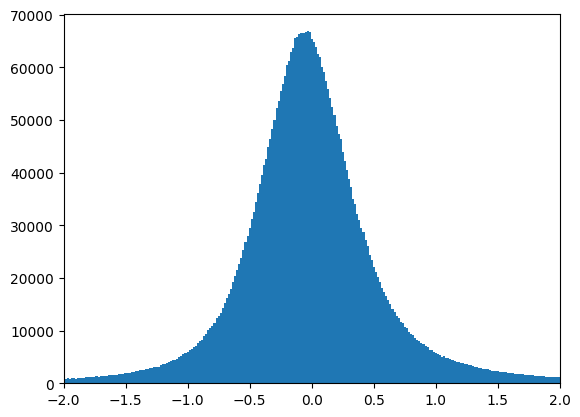

In [13]:
plt.hist(ss_2d.flatten(),bins=1000)
plt.xlim(-2,2)

In [14]:
def RMSH(dem):
    dem_mean = np.nanmean(dem)
    rmsh = np.sqrt(np.nansum((dem - dem_mean) ** 2) / (np.sum(~np.isnan(dem)) - 1))
    return rmsh


rmsh_1d = np.zeros(data_cut.shape[0])
for i in range(data_cut.shape[0]):
    bs_1d, ss_1d = filter_1d_fft(data_cut[i, :], interval)
    rmsh_1d[i] = RMSH(ss_1d)
rmsh_2d = RMSH(ss_2d)
print(np.mean(rmsh_1d), rmsh_2d)

0.509125648574589 0.7336527329504622


In [15]:
from numpy.fft import fft, ifft, fftshift
def autocorrelation_1d(_dem):
    _mean_1d = np.mean(_dem)
    _Var_1d_1 = np.sum((_dem-_mean_1d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_1d = np.pad(_dem - _mean_1d, _pad_size, 'constant')
    _fft_1d = fft(_expanded_ss_1d)
    _fft_1d_conj = np.conj(_fft_1d)
    _F_prod = _fft_1d * _fft_1d_conj
    _rho_num = fftshift(ifft(_F_prod)).real
    _autocorrelation_1d = _rho_num[_pad_size:-_pad_size]/_Var_1d_1
    return _autocorrelation_1d[center_index:]
autocorrelation_1d_fft = np.zeros((data_cut.shape[0],center_index+1))
for i in range(data_cut.shape[0]):
    autocorrelation_1d_fft[i,:] = autocorrelation_1d(_dem=filter_1d_fft(data_cut[i,:],interval)[1])

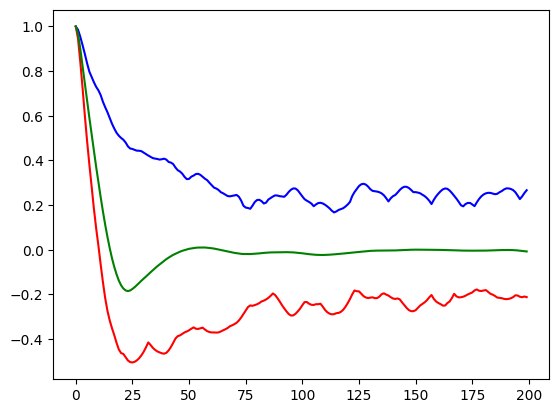

In [16]:
autocorrelation_1d_max = np.max(autocorrelation_1d_fft,axis=0)
autocorrelation_1d_min = np.min(autocorrelation_1d_fft,axis=0)
autocorrelation_1d_mean = np.mean(autocorrelation_1d_fft,axis=0)
plt.plot(autocorrelation_1d_max[:200],'b')
plt.plot(autocorrelation_1d_min[:200],'r')
plt.plot(autocorrelation_1d_mean[:200],'g')

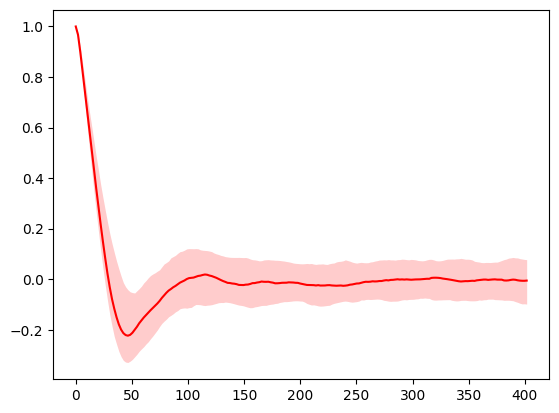

In [55]:
# 创建图形和轴
fig, ax = plt.subplots()

length = 200

x_data = np.arange(0,length,1)*map_scale
ar_up = np.percentile(autocorrelation_1d_fft[:,:length],85,axis=0)
ar_med = np.percentile(autocorrelation_1d_fft[:,:length],50,axis=0)
ar_down = np.percentile(autocorrelation_1d_fft[:,:length],15,axis=0)

ax.plot(x_data,ar_med,'r')
ax.fill_between(x_data,ar_down,ar_up,alpha=0.2,color='red',linewidth=0)

[1.11109622 0.08437288 0.08016903]


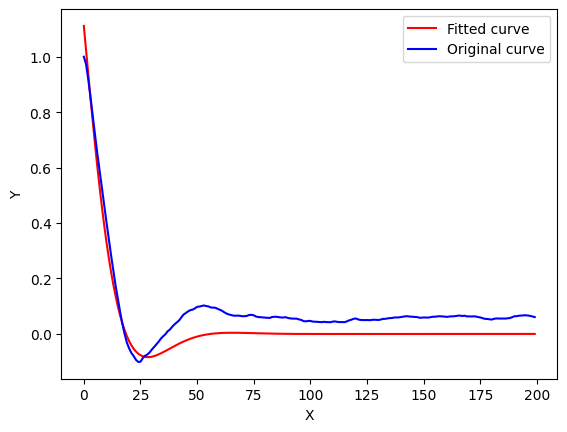

In [56]:
from scipy.optimize import curve_fit
# 定义一个模型函数，这里我们假设它是 np.exp(-b*x) * np.cos(a*x + phi) 的形式
# 其中 a, b, phi 是我们需要拟合的参数
# 定义sinc函数，使用NumPy的向量化操作
y_data = np.percentile(autocorrelation_1d_fft[:,:length],80,axis=0)
def sinc(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.sin(np.pi * x) / (np.pi * x)
        result[x == 0] = 1  # 当x为0时，设置结果为1
    return result

def sinc_model(x, a, b):
    return a * sinc(b * x)
    

def model_func(x, a, b,c,d):
    return np.exp(-a*x) * sinc_model(x, b, c)

# 定义高斯乘以sinc的复合函数
def gauss_sinc(x, A, x0, sigma, B):
    return np.exp(-(x - x0)**2 / (2 * sigma**2)) * sinc_model(x,A,B)

def test_2(x,a,b,c,d):
    return np.exp(-(x - a)**2 / (2 * c**2)) * np.cos(b*x) * d

def modulated_exponential(x, A, omega, lambda_):
    return A * (np.cos(omega * x)) * np.exp(-lambda_ * x)

def exponential(x, A, lambda_):
    return A * np.exp(-lambda_ * x)

def gaussian(x, A, x0, sigma):
    return np.exp(-(x - x0)**2 / (2 * sigma**2))
 
# 使用 curve_fit 来找到最佳拟合参数
popt, pcov = curve_fit(modulated_exponential, np.arange(0,length,1), y_data,maxfev=100000)
# popt包含拟合的参数A, x0, sigma, B
A, omega, lambda_ = popt
print(popt)
 
# 使用最佳拟合参数来绘制拟合曲线
x_fit = np.arange(0,length,1)
y_fit = modulated_exponential(x_fit, A, omega, lambda_)
plt.plot(x_fit, y_fit, 'r-', label='Fitted curve')
plt.plot(y_data,'b',label='Original curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

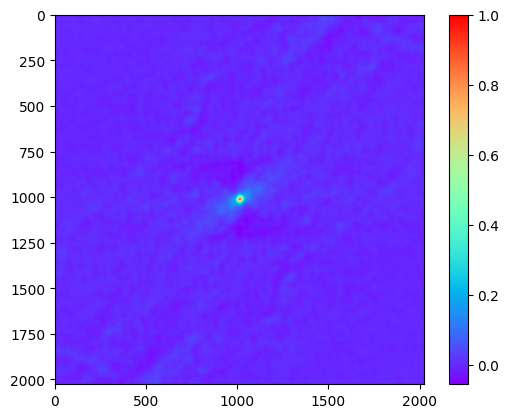

In [57]:
from numpy.fft import fft2, ifft2, fftshift
def autocorrelation_2d(_dem):
    _mean_2d = np.nanmean(_dem)
    _Var_2d_1 = np.sum((_dem-_mean_2d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_2d = np.pad(_dem - _mean_2d, (_pad_size, _pad_size), 'constant')
    _fft_2d = fft2(_expanded_ss_2d)
    _fft_2d_conj = np.conj(_fft_2d)
    _F_prod = _fft_2d * _fft_2d_conj
    _rho_num = fftshift(ifft2(_F_prod)).real
    _autocorrelation_2d = _rho_num[_pad_size:-_pad_size, _pad_size:-_pad_size]/_Var_2d_1
    return _autocorrelation_2d

autocorrelation_2d_1 = autocorrelation_2d(ss_2d)
plt.imshow(autocorrelation_2d_1,cmap='rainbow')
plt.colorbar()
plt.show()

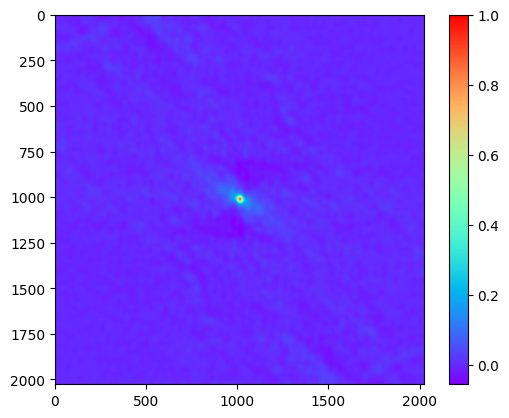

In [58]:
autocorrelation_2d_2 = autocorrelation_2d(np.flipud(ss_2d))
plt.imshow(autocorrelation_2d_2,cmap='rainbow')
plt.colorbar()
plt.show()

In [59]:
x = np.arange(-center_index,center_index+1,1) * map_scale
xx,yy = np.meshgrid(x,x)

In [60]:
distance_2d = np.sqrt(xx ** 2 + yy ** 2)

In [61]:
distance_2d_flatten = distance_2d.flatten()
autocorrelation_2d_1_flatten = autocorrelation_2d_1.flatten()
# autocorrelation_2d_1_flatten根据distance_2d_flatten排序
sorted_index = np.argsort(distance_2d_flatten)
distance_2d_flatten = distance_2d_flatten[sorted_index]
autocorrelation_2d_1_flatten = autocorrelation_2d_1_flatten[sorted_index]
# autocorrelation_2d_1_flatten按照map_scale的距离进行分类
distance_2d_flatten_unique = np.unique(distance_2d_flatten)
# 剔除distance大于length*map_scale的点
distance_2d_flatten_unique = distance_2d_flatten_unique[distance_2d_flatten_unique <= length*map_scale]
delta = np.arange(0, length,1) * map_scale
distance_2d_flatten_list = []
autocorrelation_2d_1_flatten_list = []
for i in range(len(delta)-1):
    distance_2d_flatten_list.append(distance_2d_flatten[(distance_2d_flatten >= delta[i]) & (distance_2d_flatten < delta[i+1])])
    autocorrelation_2d_1_flatten_list.append(autocorrelation_2d_1_flatten[(distance_2d_flatten >= delta[i]) & (distance_2d_flatten < delta[i+1])])

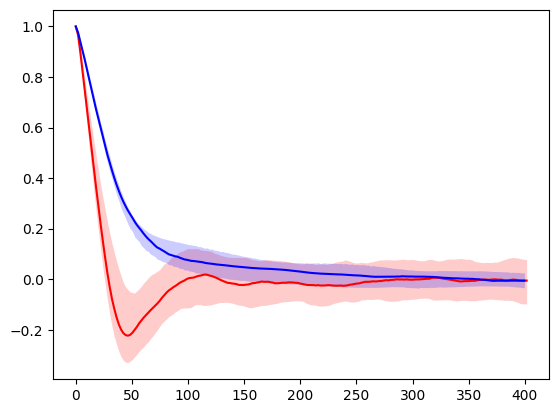

In [62]:
x_data_2d = np.arange(0, len(distance_2d_flatten_list),1) * map_scale

# autocorrelation_2d_1_flatten_list每一行求percentiles, 得到80,50,15的分位数
ar_up_list = []
ar_med_list = []
ar_down_list = []
for i in range(len(autocorrelation_2d_1_flatten_list)):
    ar_up_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i],85))
    ar_med_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i],50))
    ar_down_list.append(np.percentile(autocorrelation_2d_1_flatten_list[i],15))

ar_up_2d = np.array(ar_up_list)
ar_med_2d = np.array(ar_med_list)
ar_down_2d = np.array(ar_down_list)

# 创建图形和轴
fig, ax = plt.subplots()

# 1D autocorrelation
x_data = np.arange(0,length,1)*map_scale
ar_up = np.percentile(autocorrelation_1d_fft[:,:length],85,axis=0)
ar_med = np.percentile(autocorrelation_1d_fft[:,:length],50,axis=0)
ar_down = np.percentile(autocorrelation_1d_fft[:,:length],15,axis=0)

ax.plot(x_data,ar_med,'r')
ax.fill_between(x_data,ar_down,ar_up,alpha=0.2,color='red',linewidth=0)

ax.plot(x_data_2d,ar_med_2d,'b')
ax.fill_between(x_data_2d,ar_down_2d,ar_up_2d,alpha=0.2,color='blue',linewidth=0)

# 2D autocorrelation

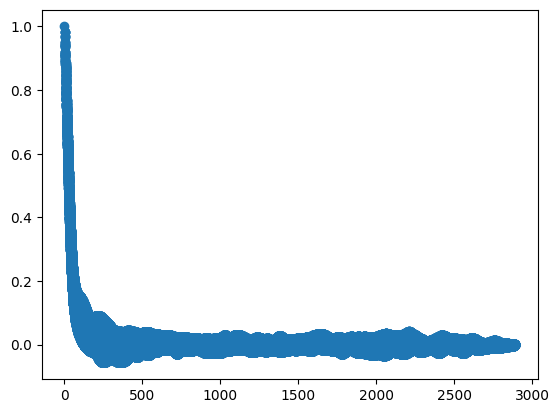

In [63]:
plt.scatter(distance_2d.flatten(),autocorrelation_2d_1.flatten())